In [6]:
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import os
import numpy as np
from matplotlib.ticker import MultipleLocator
import os

import utils as ut

In [7]:
# function to perform analysis of efficiency results
def analyzeResults(pt, pt_bins, results):
    effs, eff_errs = [], []
    # loop over the pT bins
    for i in range(len(pt_bins) - 1):
        in_bin_extracted = (pt >= pt_bins[i]) & (pt < pt_bins[i+1])
        N = np.sum(in_bin_extracted)
        if np.sum(in_bin_extracted) > 0:
            # Check how many were correctly labeled as high pT (label 0)
            labeled_high_pt = (results[in_bin_extracted] == 0)
            npass = np.sum(labeled_high_pt)
            eff = npass / N
            eff_err = efficiency_error(eff, N)
            # save
            effs.append(eff)
            eff_errs.append(eff_err)
        else:
            effs.append(0)
            eff_errs.append(0)
    return np.array(effs), np.array(eff_errs)
    
# efficiency error calculation
def efficiency_error(eff, N):
    ''' 
    See section 2.2.1 https://lss.fnal.gov/archive/test-tm/2000/fermilab-tm-2286-cd.pdf
    eff = estimate of the efficiency
    N = sample size
    '''
    return np.sqrt(eff * (1 - eff) / N)

In [ ]:
datadir = "/asic/projects/C/CMS_PIX_28/abadea/working/filter/model_pipeline/tmp/"
confs = [
    {
        "qm_charge_levels" : [400, 1600, 2400], 
        "asic_path" : "/mnt/local/CMSPIX28/data/ChipVersion1_ChipID17_SuperPix1/2025.08.10_10.36.52_DNN_vth0-0.020_vth1-0.085_vth2-0.135/final_results.npy",
        "asic_yprofiles_path" : "/mnt/local/CMSPIX28/data/ChipVersion1_ChipID17_SuperPix1/2025.08.10_10.36.52_DNN_vth0-0.020_vth1-0.085_vth2-0.135/yprofiles.csv"
        # "asic_path" : "/mnt/local/CMSPIX28/data/ChipVersion1_ChipID17_SuperPix1/2025.08.07_12.02.29_DNN_vth0-0.080_vth1-0.160_vth2-0.320/final_results.npy" # higher threshold
        },
    {
        "qm_charge_levels" : [1000, 1600, 2400], 
        "asic_path" : "/mnt/local/CMSPIX28/data/ChipVersion1_ChipID17_SuperPix1/2025.08.08_11.00.19_DNN_vth0-0.087_vth1-0.139_vth2-0.208/final_results.npy",
        "asic_yprofiles_path" : "/mnt/local/CMSPIX28/data/ChipVersion1_ChipID17_SuperPix1/2025.08.08_11.00.19_DNN_vth0-0.087_vth1-0.139_vth2-0.208/yprofiles.csv"
        },
]
for conf in confs:
    dir = os.path.join(datadir, "_".join(map(str, conf["qm_charge_levels"])))
    conf["pt"] = np.load(os.path.join(dir, "pts.npy"))
    conf["ylocals"] = np.load(os.path.join(dir, "ylocals.npy"))
    conf["clslabels"] = np.load(os.path.join(dir, "clslabels.npy"))
    conf["yprofiles"] = np.load(os.path.join(dir, "yprofiles.npy"))
    conf["keras_predictions"] = np.load(os.path.join(dir, "keras_predictions.npy"))
    conf["keras_predictions"] = np.argmax(conf["keras_predictions"], axis=1)
    conf["qkeras_predictions"] = np.load(os.path.join(dir, "qkeras_predictions.npy"))
    conf["qkeras_predictions"] = np.argmax(conf["qkeras_predictions"], axis=1)
    conf["asic_predictions"] = np.load(conf["asic_path"])
    conf["asic_yprofiles"] = np.loadtxt(conf["asic_yprofiles_path"], delimiter=",")
    print(conf["asic_predictions"].shape)

(178150,)
(299739,)


Text(1, 0, 'y-local [mm]')

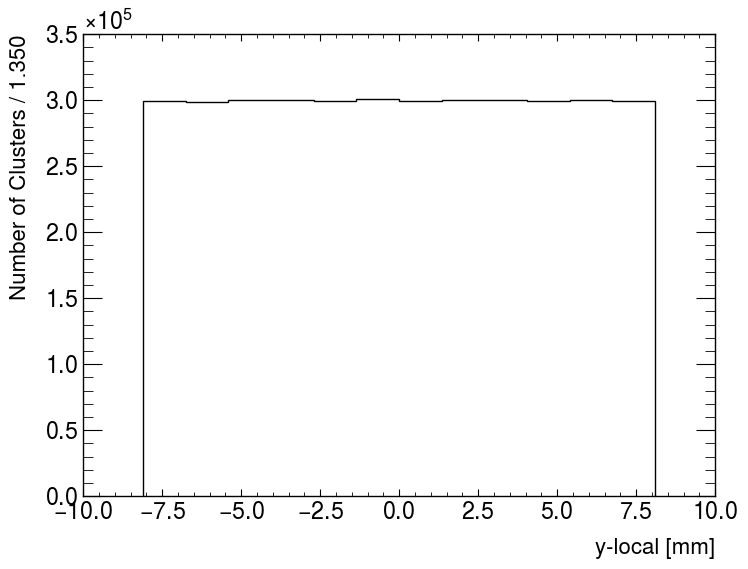

In [9]:
# plot ylocals
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(-8.1, 8.1, 13)
bw = bins[1] - bins[0]
ax.hist(confs[0]["ylocals"], bins=bins, histtype='step', color='black')
ax.set_ylabel(f"Number of Clusters / {bw:.3f}", fontsize=16)
ax.set_xlabel("y-local [mm]", fontsize=16)


Bin 6: 299739 entries in ylocal range [0.00, 1.35)
(178150,) 299739
Bin 6: 299739 entries in ylocal range [0.00, 1.35)
(299739,) 299739


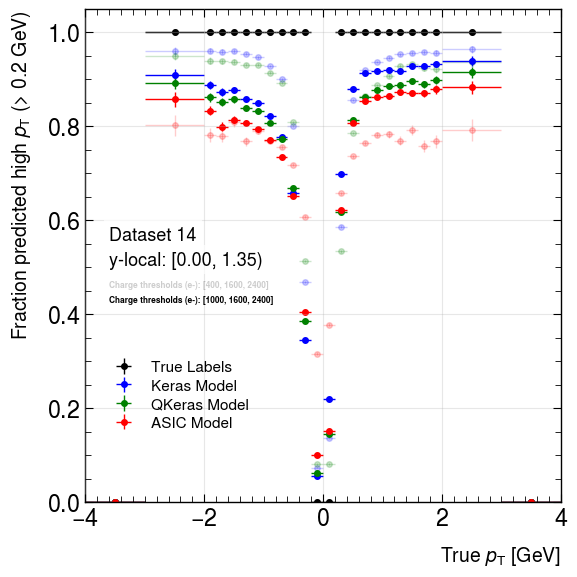

In [10]:
from PyPDF2 import PdfMerger

# Create bins for true pT values from -4 to 4
bins_pos = np.unique(np.concatenate([
    np.linspace(0, 1, 5, endpoint=False),
    np.linspace(1, 2, 5, endpoint=False),
    np.linspace(2, 4, 3, endpoint=True)
]))
bins_neg = -1 * bins_pos[::-1]
pt_bins = np.unique(np.concatenate([bins_neg, bins_pos]))
bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
bin_widths = np.diff(pt_bins)

# binNumberList = range(len(bins) - 1) # full range
binNumberList = [6] # just the 0th bin, as chosen by Giuseppe
for bin_number in binNumberList:
    
    # Select the range of the i-th bin of ylocal
    ylocal_min = bins[bin_number]
    ylocal_max = bins[bin_number + 1]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6,6))

    # Add text for ylocal bin range
    ax.text(0.05, 0.56, f"Dataset 14", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.text(0.05, 0.51, f"y-local: [{ylocal_min:.2f}, {ylocal_max:.2f})", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # plot per configuration
    for iC, conf in enumerate(confs):

        # interested_range = (ylocal_min, ylocal_max)
        mask = (conf["ylocals"] >= ylocal_min) & (conf["ylocals"] < ylocal_max)
        mask_noNoiseInjected = (conf["yprofiles"] == conf["asic_yprofiles"]).all(axis=1)
        print(f"Bin {bin_number}: {mask.sum()} entries in ylocal range [{ylocal_min:.2f}, {ylocal_max:.2f})")
        
        # results
        true_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["clslabels"][mask])
        keras_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["keras_predictions"][mask])
        qkeras_res_bin = analyzeResults(conf["pt"][mask], pt_bins, conf["qkeras_predictions"][mask])
        asic_res_bin = analyzeResults(conf["pt"][mask][:conf["asic_predictions"].shape[0]], pt_bins[:conf["asic_predictions"].shape[0]], conf["asic_predictions"])
        print(conf["asic_predictions"].shape, mask.sum())

        conf["asic_predictions_yprofileMatch"] = conf["asic_predictions"][mask_noNoiseInjected]
        asic_noNoiseInjected_res_bin = analyzeResults(conf["pt"][mask & mask_noNoiseInjected][:conf["asic_predictions_yprofileMatch"].shape[0]], pt_bins, conf["asic_predictions_yprofileMatch"])

        # plot settings
        light = (conf["qm_charge_levels"] == [400, 1600, 2400])
        alpha = 0.2 if light else 1.0  # make the first configuration more transparent
        labels = [ "True Labels", "Keras Model", "QKeras Model", "ASIC Model"]
        if light:
            labels = ["" for _ in labels]  # hide labels for the first configuration
        
        # plot error bars
        ax.errorbar(bin_centers, true_res_bin[0], xerr=bin_widths/2, yerr=true_res_bin[1], fmt='o', linewidth=1, markersize=4, color="black", label=labels[0], alpha=alpha)
        ax.errorbar(bin_centers, keras_res_bin[0], xerr=bin_widths/2, yerr=keras_res_bin[1], fmt='o', linewidth=1, markersize=4, color="blue", label=labels[1], alpha=alpha)
        ax.errorbar(bin_centers, qkeras_res_bin[0], xerr=bin_widths/2, yerr=qkeras_res_bin[1], fmt='o', linewidth=1, markersize=4, color="green", label=labels[2], alpha=alpha)
        ax.errorbar(bin_centers, asic_res_bin[0], xerr=bin_widths/2, yerr=asic_res_bin[1], fmt='o', linewidth=1, markersize=4, color="red", label=labels[3], alpha=alpha)

        ax.text(0.05, 0.45 - iC*0.03, f"Charge thresholds (e-): {conf['qm_charge_levels']}", transform=ax.transAxes, fontsize=6, verticalalignment='top', fontweight='bold', alpha=alpha)


    # set plot styles
    ax.set_xlabel(r'True $p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel(r'Fraction predicted high $p_{\mathrm{T}}$ (> 0.2 GeV)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-4, 4)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=6)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))

    ax.legend(loc='lower left', fontsize=11, bbox_to_anchor=(0, 0.1))
    plt.tight_layout()
    plt.show()

    # Create 'plots' directory if it doesn't exist
    os.makedirs("plots", exist_ok=True)

    # Save the current figure as a PDF in the 'plots' directory
    pdf_filename = f"plots/eff_vs_pt_ylocal_bin_{bin_number}.pdf"
    fig.savefig(pdf_filename)

# After the loop, concatenate all PDFs into one (run this after the loop)
if len(binNumberList) > 1:
    merger = PdfMerger()
    pdf_files = [f"plots/eff_vs_pt_ylocal_bin_{i}.pdf" for i in binNumberList]
    for pdf in pdf_files:
        merger.append(pdf)
    merger.write("plots/all_eff_vs_pt_ylocal_bins.pdf")
    merger.close()
